In [1]:
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

##### import data

#### 95th percentile  treshold

In [2]:
import os
import pandas as pd

def process_commit_history(csv_file, current_time="2024-1-1"):
    df = pd.read_csv(csv_file)
    df = df.dropna(subset=['date'])
    if df.empty:
        return None
    
    df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
    
    # Filter the DataFrame to include only dates up to and including November 1, 2023
    cut_off_date = '2023-11-1'
    df = df[df['date'] <= pd.to_datetime(cut_off_date)]
    
    # Check again if DataFrame is empty after filtering by date
    if df.empty:
        return None
    
    df['timestamp'] = df['date'].astype('datetime64[s]')
    df = df.sort_values(by=['timestamp'], ascending=True)
    
    # Ensure there's at least one row before proceeding
    if not df.empty:
        df['interval'] = df['timestamp'].diff().dt.total_seconds()
        
        # Calculate the mean and standard deviation of commit intervals
        mean_interval = df['interval'].mean()
        sd_interval = df['interval'].std()
        
        Z = df['interval'].max()
        percentile_95 = df['interval'].dropna().quantile(0.99)
        T = pd.to_datetime(current_time)
        T_X_n = (T - df['timestamp'].iloc[-1]).total_seconds()
        time_since_last_commit_days = T_X_n / (60 * 60 * 24)
            
        classification = "unknown"
        if T_X_n > Z:
            # Reclassify as "alive" if within a certain SD from the mean
            if abs(T_X_n - mean_interval) < sd_interval:
                classification = "alive"
            else:
                classification = "dead"
        elif T_X_n < percentile_95:
            classification = "alive"
            
        mean_interval = mean_interval / (60 * 60 * 24)
        
        repo_name = os.path.basename(csv_file).split('.')[0]
        return {
            'Repo': repo_name,
            'Z': Z,
            'T_X_n': T_X_n,
            'Percentile_95': percentile_95,
            'MeanInterval(days)': mean_interval,
            'SDInterval': sd_interval,
            'Classification': classification,
            'TimeSinceLastCommit(days)': time_since_last_commit_days
        }
    else:
        return None
    
folder_path = '/Users/ethan/Documents/Data science/MQP/main_repo_df/Data/CommitData'  
results_list = []  

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        csv_path = os.path.join(folder_path, file_name)
        result = process_commit_history(csv_path)
        if result:  # Only add if result is not None
            results_list.append(result)

C:\Users\ethan\AppData\Local\Temp\ipykernel_17364\939561772.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
C:\Users\ethan\AppData\Local\Temp\ipykernel_17364\939561772.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)


    classification = "unknown"
    if T_X_n > Z:
        classification = "dead"
        # If classified as dead but within 1 SD from the mean, reclassify as alive
        if abs(T_X_n - mean_interval) < sd_interval:
            classification = "alive"
    elif T_X_n < percentile_95:
        classification = "alive"
   

In [6]:
# Use pd.concat to create a DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

In [8]:
results_df.head(1)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,73483.954057,dead,858.4439


In [9]:
results_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,52620549.82,30.238753,1.018087e+07,alive,114.686644
...,...,...,...,...,...,...,...,...
1745,C_zpao_qrcode,31729003.0,5514118.0,17436501.08,14.949914,3.856684e+06,alive,63.820810
1746,C_zqzess_rule_for_quantumultX,606525.0,5437634.0,605081.98,1.167113,1.754097e+05,dead,62.935579
1747,C_zs9024_quick_psd2ugui,58344447.0,57677255.0,28574030.14,27.239227,7.661345e+06,unknown,667.560822
1748,C_zxing_zxing,5990254.0,5388515.0,1893611.80,1.559213,3.716090e+05,unknown,62.367072


In [10]:
results_df['TimeSinceLastCommit(days)'].describe()

count    1750.000000
mean      758.010614
std       916.319340
min        61.000359
25%        81.133247
50%       304.054242
75%      1186.422934
max      5020.900463
Name: TimeSinceLastCommit(days), dtype: float64

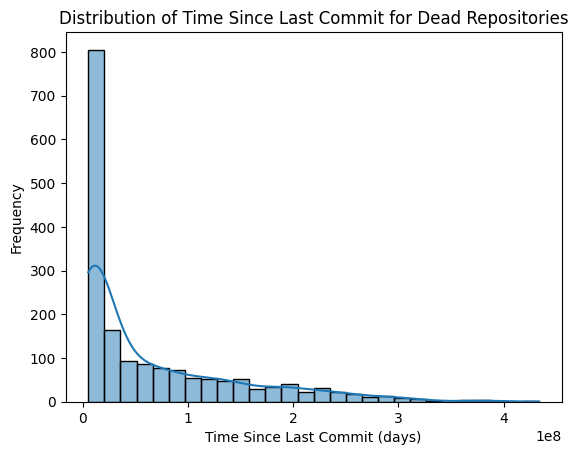

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['T_X_n'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


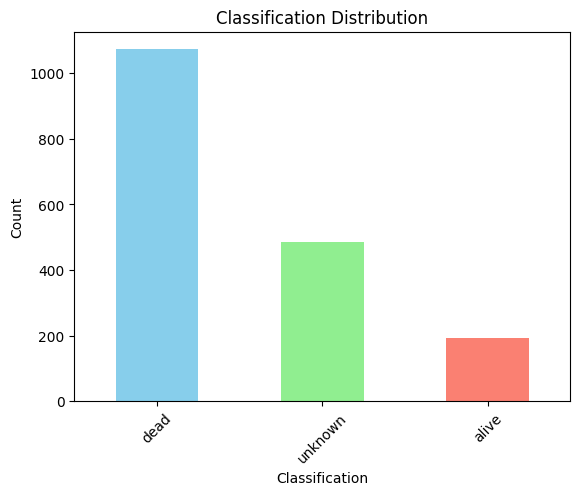

In [12]:
import matplotlib.pyplot as plt

classification_counts = results_df['Classification'].value_counts()
classification_counts.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Classification Distribution')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Dead repos 

In [13]:
dead_repos_df = results_df[results_df['Classification'] == 'dead']
dead_repos_df.head(10)

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
5,C_78778443_QingScan,7278693.0,17337768.0,1233153.85,0.808845,4.627651e+05,dead,200.668611
6,C_89996462_Quantumult-X,4064823.0,5567723.0,430090.90,0.500326,2.449188e+05,dead,64.441238
7,C_9magnets_iOS-Developer-and-Designer-Intervie...,52066745.0,207744379.0,36757206.98,20.484703,8.236624e+06,dead,2404.448831
9,C_AbhishekChourasiya_Leetcode-Questions,356.0,128771801.0,356.00,0.004120,NaN,dead,1490.414363
10,C_abuanwar072_Quiz-App-Flutter,28052746.0,57097704.0,27029863.35,68.840289,1.124620e+07,dead,660.853056
11,C_academind_node-restful-api-tutorial,126883.0,192108057.0,125676.79,0.770515,8.529193e+04,dead,2223.472882


In [14]:

# Selecting a random row from `dead_repos_df`
random_row = dead_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
684,C_josephmisiti_awesome-machine-learning,3002726.0,5387304.0,1469361.0,1.785296,316015.003988,dead,62.353056


In [15]:
sorted_dead_repos_df = dead_repos_df.sort_values(by='TimeSinceLastCommit(days)')
sorted_dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
37,C_Alexander-MacDonald_test-repo,2495195.0,5270431.0,2396272.00,5.829762,1.113324e+06,dead,61.000359
1251,C_QuestPDF_QuestPDF,3350155.0,5272495.0,1507475.12,1.416817,3.022375e+05,dead,61.024248
166,C_BuilderIO_qwik,2427659.0,5272579.0,347171.12,0.307193,8.603982e+04,dead,61.025220
409,C_facebook_rocksdb,4881432.0,5273184.0,311287.66,0.378022,9.198788e+04,dead,61.032222
1127,C_PowerShell_PowerShell,2396747.0,5273625.0,334886.64,0.305911,7.066334e+04,dead,61.037326
...,...,...,...,...,...,...,...,...
1137,C_punkave_phpQuery,364.0,382092634.0,364.00,0.004213,NaN,dead,4422.368449
875,C_lorensiuswlt_NewQuickAction3D,7033736.0,385339174.0,6786744.76,18.357984,3.067312e+06,dead,4459.944144
570,C_huacnlee_quora,4059969.0,385840367.0,795069.36,0.371762,2.176633e+05,dead,4465.744988
1112,C_placemarker_jQuery-MD5,7546712.0,396091502.0,7231883.04,19.857190,2.504764e+06,dead,4584.392384


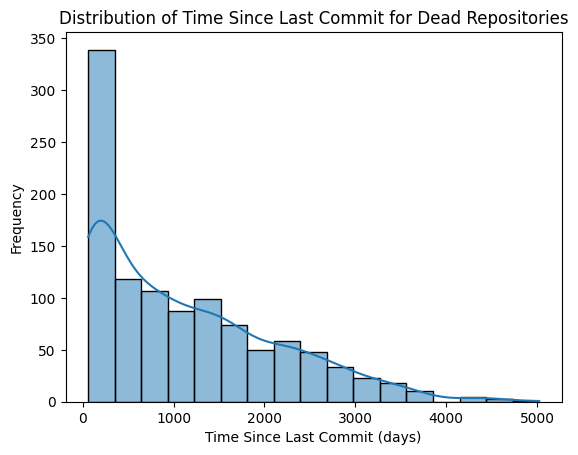

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(dead_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()


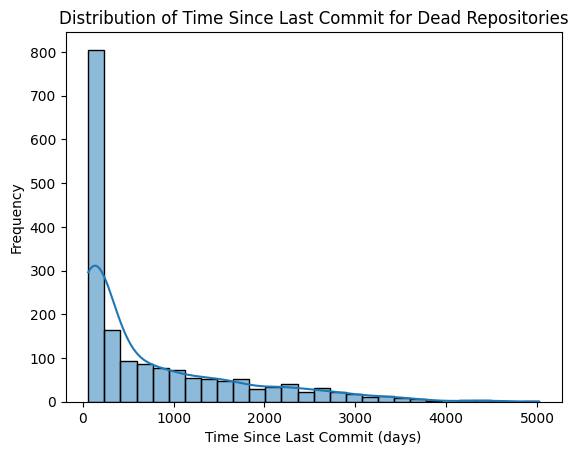

In [17]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(results_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

#### Alive repos 

In [18]:
alive_repos_df = results_df[results_df['Classification'] == 'alive']
alive_repos_df.head(10)


,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,5.262055e+07,30.238753,1.018087e+07,alive,114.686644
12,C_acmerobotics_road-runner-quickstart,17714735.0,6144024.0,1.625137e+07,12.270346,2.756169e+06,alive,71.111389
29,C_airbus-seclab_qemu_blog,24165616.0,18551364.0,2.367059e+07,51.195907,8.593245e+06,alive,214.714861
31,C_aizvorski_video-quality,118991936.0,83753597.0,1.069994e+08,154.036456,3.033368e+07,alive,969.370336
35,C_alex-spataru_QSimpleUpdater,25583517.0,6849015.0,2.510700e+07,27.920724,5.410218e+06,alive,79.271007
45,C_alibaba_QLExpress,35595278.0,9841532.0,1.426778e+07,7.221745,2.901226e+06,alive,113.906620
55,C_amplitude_redux-query,32912945.0,9961449.0,1.258979e+07,6.162523,2.625425e+06,alive,115.294549
70,C_anujdevopslearn_InterviewQuestions,9555506.0,7414136.0,9.132857e+06,13.609953,2.068203e+06,alive,85.811759
77,C_appdev-projects_classroom-queries-debug-v1,80982283.0,13058914.0,7.745203e+07,183.008106,3.217269e+07,alive,151.144838
78,C_appdev-projects_msm-queries-v1,50573372.0,13058900.0,4.735768e+07,82.899101,1.663294e+07,alive,151.144676


In [19]:
# Selecting a random row from `dead_repos_df`
random_row = alive_repos_df.sample(n=1)
random_row

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
234,C_ColinDuquesnoy_QDarkStyleSheet,22909892.0,5805775.0,8936737.12,4.77226,1.953756e+06,alive,67.19647


In [20]:
sorted_alive_repos_df = alive_repos_df.sort_values(by='TimeSinceLastCommit(days)', ascending=False)
sorted_alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
196,C_chentao0707_QrCodeScan,193643383.0,96135592.0,1.768451e+08,241.074126,6.076016e+07,alive,1112.680463
342,C_dwa012_html5-qrcode,163789712.0,89897166.0,1.010558e+08,65.078948,2.482597e+07,alive,1040.476458
31,C_aizvorski_video-quality,118991936.0,83753597.0,1.069994e+08,154.036456,3.033368e+07,alive,969.370336
1514,C_taitems_Aristo-jQuery-UI-Theme,254797562.0,82126395.0,1.502307e+08,90.497521,3.781132e+07,alive,950.536979
1589,C_udacity_AdvancedAndroid_ClassicalMusicQuiz,141406799.0,69243941.0,1.235064e+08,120.394587,3.771865e+07,alive,801.434502
...,...,...,...,...,...,...,...,...
1273,C_quil_quil,39905876.0,5294826.0,7.172433e+06,4.237007,1.989662e+06,alive,61.282708
497,C_GoogleChromeLabs_quicklink,35700958.0,5287234.0,6.962342e+06,3.962560,2.103640e+06,alive,61.194838
893,C_mame_quine-relay,20481206.0,5282426.0,1.369590e+07,7.753194,2.323513e+06,alive,61.139190
1261,C_quickfixgo_quickfix,17657397.0,5279174.0,7.139102e+06,4.526876,1.422050e+06,alive,61.101551


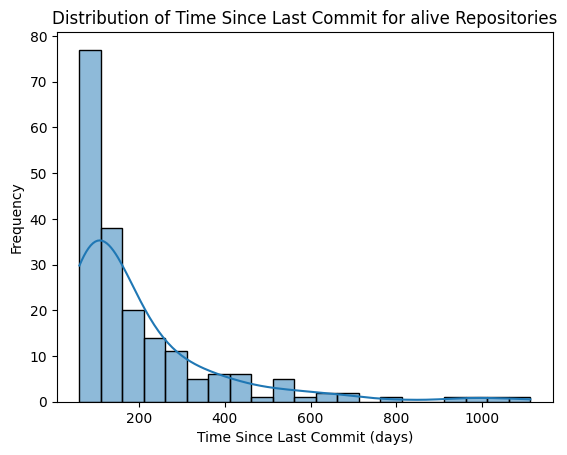

In [21]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(alive_repos_df['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for alive Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

In [22]:
dead_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
5,C_78778443_QingScan,7278693.0,17337768.0,1233153.85,0.808845,4.627651e+05,dead,200.668611
...,...,...,...,...,...,...,...,...
1741,C_zhuxuedefeng_AiQiangGUO,8192130.0,82317576.0,7539664.08,12.130486,2.297861e+06,dead,952.749722
1742,C_ziadoz_awesome-php,9841058.0,45455853.0,3449589.05,2.447083,6.796128e+05,dead,526.109410
1744,C_Zoinkwiz_quest-helper,1859833.0,5743575.0,820505.60,0.660968,1.590490e+05,dead,66.476562
1746,C_zqzess_rule_for_quantumultX,606525.0,5437634.0,605081.98,1.167113,1.754097e+05,dead,62.935579


In [23]:
unknown = results_df[results_df['Classification'] == 'unknown']

In [24]:
alive_repos_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,5.262055e+07,30.238753,1.018087e+07,alive,114.686644
12,C_acmerobotics_road-runner-quickstart,17714735.0,6144024.0,1.625137e+07,12.270346,2.756169e+06,alive,71.111389
29,C_airbus-seclab_qemu_blog,24165616.0,18551364.0,2.367059e+07,51.195907,8.593245e+06,alive,214.714861
31,C_aizvorski_video-quality,118991936.0,83753597.0,1.069994e+08,154.036456,3.033368e+07,alive,969.370336
35,C_alex-spataru_QSimpleUpdater,25583517.0,6849015.0,2.510700e+07,27.920724,5.410218e+06,alive,79.271007
...,...,...,...,...,...,...,...,...
1724,C_yrlu_quadrotor,78648439.0,47061382.0,7.410329e+07,85.658615,2.054874e+07,alive,544.691921
1732,C_zengzhan_qqzeng-ip,29444503.0,13933318.0,1.954059e+07,13.233126,3.627429e+06,alive,161.265255
1734,C_zeromicro_go-queue,14063486.0,7122496.0,1.246406e+07,15.123347,2.495918e+06,alive,82.436296
1736,C_zestyping_q,52270700.0,19133121.0,4.036605e+07,32.336545,8.769996e+06,alive,221.448160


In [25]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Repo                       1750 non-null   object 
 1   Z                          1750 non-null   float64
 2   T_X_n                      1750 non-null   float64
 3   Percentile_95              1750 non-null   float64
 4   MeanInterval(days)         1750 non-null   float64
 5   SDInterval                 1731 non-null   float64
 6   Classification             1750 non-null   object 
 7   TimeSinceLastCommit(days)  1750 non-null   float64
dtypes: float64(6), object(2)
memory usage: 109.5+ KB


#### Unknown

In [26]:
unknown = results_df[results_df['Classification'] == 'unknown']

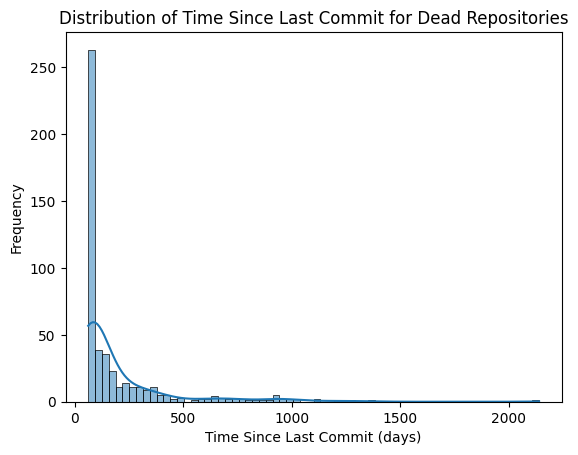

In [27]:
# Plotting the distribution of "Time Since Last Commit" for "dead" repositories
sns.histplot(unknown['TimeSinceLastCommit(days)'], kde=True)
plt.title('Distribution of Time Since Last Commit for Dead Repositories')
plt.xlabel('Time Since Last Commit (days)')
plt.ylabel('Frequency')
plt.show()

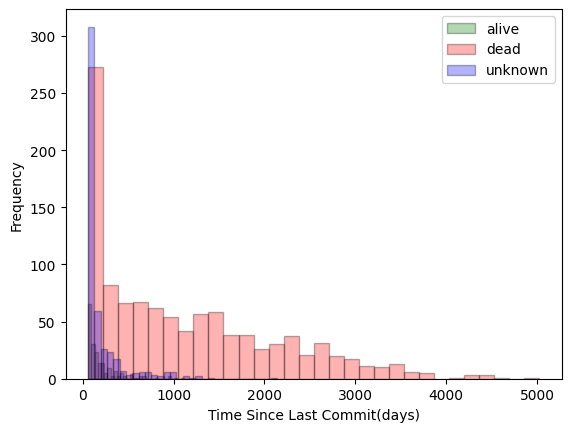

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df

# Plotting
fig, ax = plt.subplots()
colors = {'alive': 'green', 'dead': 'red', 'unknown': 'blue'}  # Example classifications
for classification, color in colors.items():
    data = results_df[results_df['Classification'] == classification]['TimeSinceLastCommit(days)']
    ax.hist(data, bins=30, alpha=0.3, label=classification, color=color, edgecolor='black')

ax.set_xlabel('Time Since Last Commit(days)')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


In [29]:
results_df

,Repo,Z,T_X_n,Percentile_95,MeanInterval(days),SDInterval,Classification,TimeSinceLastCommit(days)
0,C_0voice_campus_recruitmen_questions,1468386.0,74169553.0,57748.88,0.074827,7.348395e+04,dead,858.443900
1,C_0xAX_linux-insides,9252379.0,10496672.0,2072525.42,1.654147,5.514041e+05,dead,121.489259
2,C_1Danish-00_CompressorQueue,31220268.0,38212334.0,28776555.90,41.994261,9.370872e+06,dead,442.272384
3,C_2d-inc_developer_quest,6848421.0,127440288.0,500962.82,0.628362,4.878035e+05,dead,1475.003333
4,C_350306878_Kuai-Shua-Questions,64032394.0,9908926.0,52620549.82,30.238753,1.018087e+07,alive,114.686644
...,...,...,...,...,...,...,...,...
1745,C_zpao_qrcode,31729003.0,5514118.0,17436501.08,14.949914,3.856684e+06,alive,63.820810
1746,C_zqzess_rule_for_quantumultX,606525.0,5437634.0,605081.98,1.167113,1.754097e+05,dead,62.935579
1747,C_zs9024_quick_psd2ugui,58344447.0,57677255.0,28574030.14,27.239227,7.661345e+06,unknown,667.560822
1748,C_zxing_zxing,5990254.0,5388515.0,1893611.80,1.559213,3.716090e+05,unknown,62.367072


In [30]:
results_df.columns

Index(['Repo', 'Z', 'T_X_n', 'Percentile_95', 'MeanInterval(days)',
       'SDInterval', 'Classification', 'TimeSinceLastCommit(days)'],
      dtype='object')

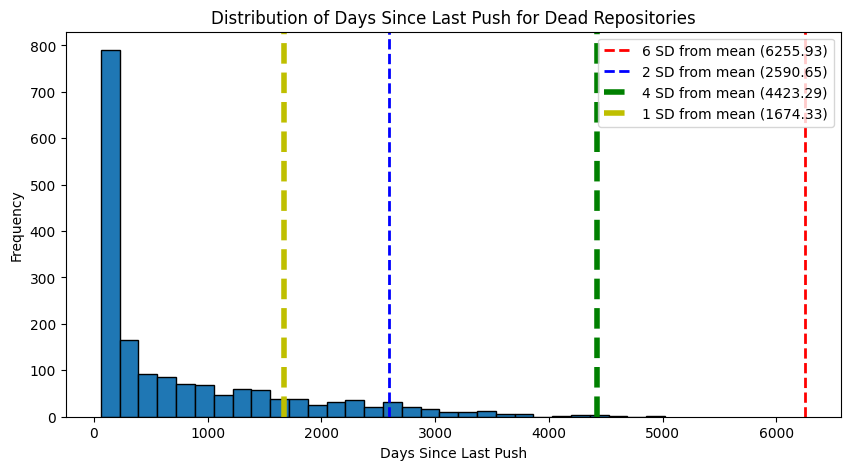

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# We'll use the filtered_repo which contains 'daysSinceLastPush' between 0 and 300
# First calculate the mean and standard deviation
mean_value = results_df['TimeSinceLastCommit(days)'].mean()
std_dev = results_df['TimeSinceLastCommit(days)'].std()

# Calculate the position of the line at 6 standard deviations from the mean
line_position = mean_value + 6*std_dev

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.hist(results_df['TimeSinceLastCommit(days)'], bins=30,  edgecolor='black')
plt.title('Distribution of Days Since Last Push for Dead Repositories')
plt.xlabel('Days Since Last Push')
plt.ylabel('Frequency')

# Calculate the position of the line at 6 standard deviations from the mean
line_position = mean_value + 6*std_dev
plt.axvline(line_position, color='r', linestyle='dashed', linewidth=2, label=f'6 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 2 standard deviations from the mean
line_position = mean_value + 2*std_dev
plt.axvline(line_position, color='b', linestyle='dashed', linewidth=2, label=f'2 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 4 standard deviations from the mean
line_position = mean_value + 4*std_dev
plt.axvline(line_position, color='g', linestyle='dashed', linewidth=4, label=f'4 SD from mean ({line_position:.2f})')

# Calculate the position of the line at 1 standard deviations from the mean
line_position = mean_value + 1*std_dev
plt.axvline(line_position, color='y', linestyle='dashed', linewidth=4, label=f'1 SD from mean ({line_position:.2f})')

# Add a legend to the plot
plt.legend()

#plt.xlim(0, 300)  # This ensures that the x-axis only shows the range from 0 to 300
plt.show()



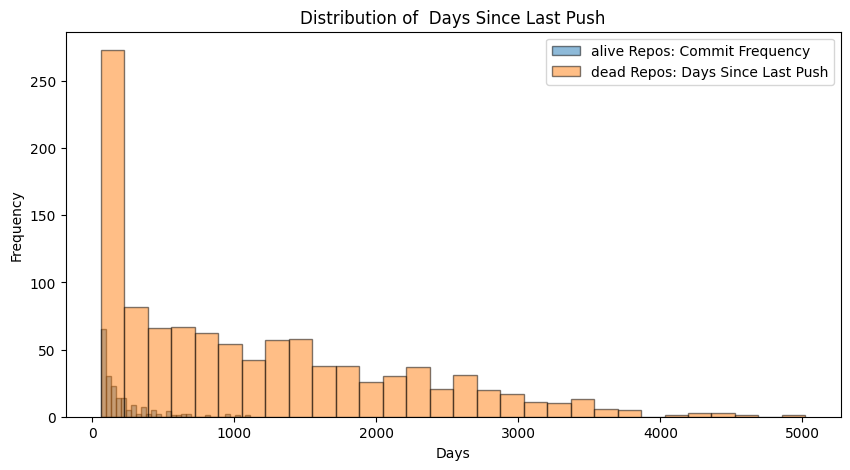

In [32]:
# Assuming 'dead_repos' and 'alive_repos' are DataFrames that contain the 'commitFrequency' and 'daysSinceLastPush' columns respectively
# We will plot the histograms for both features in one plot for comparison

plt.figure(figsize=(10, 5))

# Plotting 'commitFrequency' for dead repositories
plt.hist(alive_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='alive Repos: Commit Frequency', edgecolor='black')

# Plotting 'daysSinceLastPush' for alive repositories
plt.hist(dead_repos_df['TimeSinceLastCommit(days)'], bins=30, alpha=0.5, label='dead Repos: Days Since Last Push', edgecolor='black')

# Adding title, labels, and legend
plt.title('Distribution of  Days Since Last Push')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()



#### merge datasets

In [33]:
graph_data=pd.read_csv('../data/ml_data/graph_data_stats.csv', sep=",",index_col=0)
graph_data.drop('index', axis=1, inplace=True)
graph_data.head(1)

,owner,repo,stars,dateCreated,datePushed,numCommits,openIssues,closedIssues,totalIssues,totalAdditions,...,Fun Rt,nloc Rt,Halstead Volume,Maintainability Index,open_close_ratio,daysSinceLastPush,repoAgeDays,commitFrequency,closedIssueRatio,openIssueRatio
0,facebook,react,216019,2013-05-24 16:15:54,2023-12-08 00:51:20,16117,1557,25219,26776,2734078.0,...,0.01,0.06,1831.576017,57.03145,0.061737,0,3849,0.238816,0.941816,0.058147
